In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'CFP.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-03-31,742,-479,263,59,88,119,648,957,0,...,0,182,0,573,153,1481,-50,-53,139.9,2014-04-28
1,2014-06-30,907,-587,320,64,108,147,482,820,0,...,0,143,0,495,153,1413,206,-63,139.9,2014-07-28
2,2014-09-30,838,-544,294,58,146,111,506,861,0,...,0,145,0,494,153,1427,120,-64,139.9,2014-10-28
3,2014-12-31,860,-592,269,41,158,91,518,903,81,...,0,68,0,255,229,1460,110,-55,135.3,2015-02-24
4,2015-03-31,930,-626,304,47,214,137,640,1113,0,...,0,183,0,616,229,1822,33,-46,135.3,2015-04-28


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-03-31,2023-04-28,120.99,1385,-1238,148,-144,950,413,1258,...,886,6655,0,22,72,938,214,2576,-226,-80
37,2023-06-30,2023-07-28,118.90,1446,-1139,308,-49,861,389,992,...,864,6287,0,64,72,882,160,2368,184,-142
38,2023-09-30,2023-10-28,118.90,1312,-1076,237,-35,838,356,917,...,867,6328,0,84,75,927,163,2399,206,-193
39,2023-12-31,2024-02-24,118.90,1283,-1067,216,-122,627,298,995,...,866,6131,0,111,75,905,115,2313,-8,-172
40,2024-03-31,2024-04-29,118.90,1468,-1117,351,-64,421,395,1122,...,861,6156,0,116,77,986,118,2394,-81,-103


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-04-28,120.99,1385,-1238,148,-144,950,413,1258,...,6655,0,22,72,938,214,2576,-226,-80,1.352063
37,2023-06-30,2023-07-28,118.90,1446,-1139,308,-49,861,389,992,...,6287,0,64,72,882,160,2368,184,-142,1.343352
38,2023-09-30,2023-10-28,118.90,1312,-1076,237,-35,838,356,917,...,6328,0,84,75,927,163,2399,206,-193,1.341033
39,2023-12-31,2024-02-24,118.90,1283,-1067,216,-122,627,298,995,...,6131,0,111,75,905,115,2313,-8,-172,1.361617
40,2024-03-31,2024-04-29,118.90,1468,-1117,351,-64,421,395,1122,...,6156,0,116,77,986,118,2394,-81,-103,1.347550


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-03-31,2023-04-28,120.99,1385,-1238,148,-144,950,413,1258,...,6655,0,22,72,938,214,2576,-226,-80,1.352063
37,2023-06-30,2023-07-28,118.90,1446,-1139,308,-49,861,389,992,...,6287,0,64,72,882,160,2368,184,-142,1.343352
38,2023-09-30,2023-10-28,118.90,1312,-1076,237,-35,838,356,917,...,6328,0,84,75,927,163,2399,206,-193,1.341033
39,2023-12-31,2024-02-24,118.90,1283,-1067,216,-122,627,298,995,...,6131,0,111,75,905,115,2313,-8,-172,1.361617
40,2024-03-31,2024-04-29,118.90,1468,-1117,351,-64,421,395,1122,...,6156,0,116,77,986,118,2394,-81,-103,1.347550


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-04-28,26.000000,2014-03-31,742.0,0.0,10.03574,139.9,0.0,0.0,88.0,...,0.486655,0.513345,0.0,0.0,0.0,0.0,0.354447,0.079515,0.0,0.0
1,2014-05-05,25.240000,2014-03-31,742.0,0.0,10.03574,139.9,0.0,0.0,88.0,...,0.486655,0.513345,0.0,0.0,0.0,0.0,0.354447,0.079515,0.0,0.0
2,2014-05-12,25.049999,2014-03-31,742.0,0.0,10.03574,139.9,0.0,0.0,88.0,...,0.486655,0.513345,0.0,0.0,0.0,0.0,0.354447,0.079515,0.0,0.0
3,2014-05-19,24.670000,2014-03-31,742.0,0.0,10.03574,139.9,0.0,0.0,88.0,...,0.486655,0.513345,0.0,0.0,0.0,0.0,0.354447,0.079515,0.0,0.0
4,2014-05-26,23.930000,2014-03-31,742.0,0.0,10.03574,139.9,0.0,0.0,88.0,...,0.486655,0.513345,0.0,0.0,0.0,0.0,0.354447,0.079515,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-04-28,26.000000,2014-03-31,742.0,0.0,10.03574,139.9,0.0,0.0,88.0,...,0.0,0.354447,0.079515,0.0,0.0,inf,2.590741,1.225539,1.694879,inf
1,2014-05-05,25.240000,2014-03-31,742.0,0.0,10.03574,139.9,0.0,0.0,88.0,...,0.0,0.354447,0.079515,0.0,0.0,inf,2.515011,1.189716,1.659055,inf
2,2014-05-12,25.049999,2014-03-31,742.0,0.0,10.03574,139.9,0.0,0.0,88.0,...,0.0,0.354447,0.079515,0.0,0.0,inf,2.496079,1.180760,1.650099,inf
3,2014-05-19,24.670000,2014-03-31,742.0,0.0,10.03574,139.9,0.0,0.0,88.0,...,0.0,0.354447,0.079515,0.0,0.0,inf,2.458214,1.162848,1.632188,inf
4,2014-05-26,23.930000,2014-03-31,742.0,0.0,10.03574,139.9,0.0,0.0,88.0,...,0.0,0.354447,0.079515,0.0,0.0,inf,2.384478,1.127967,1.597307,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

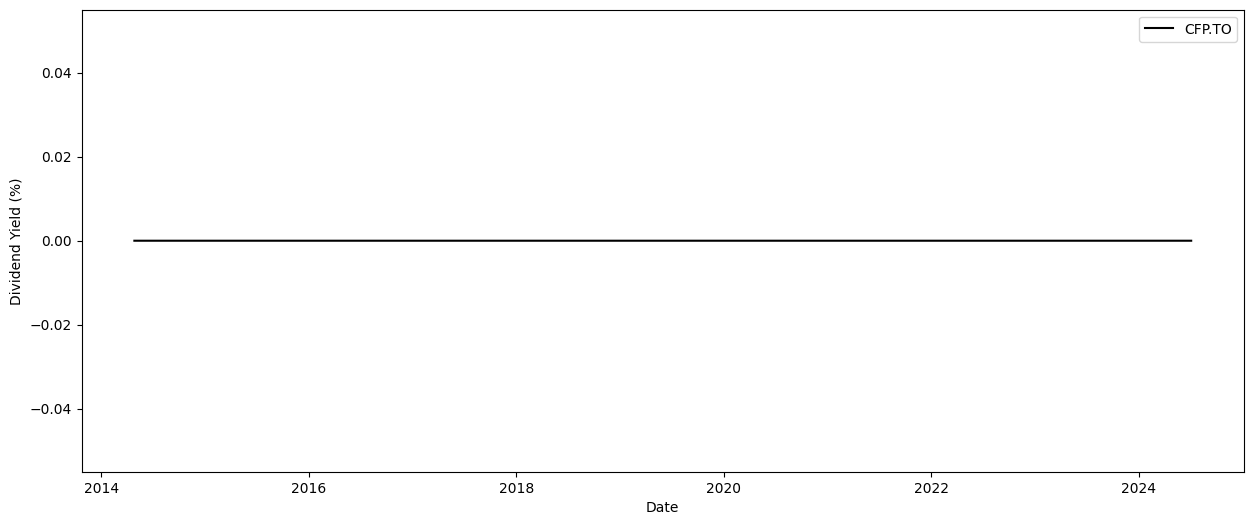

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.556099
share_price      1.000000
Name: share_price, dtype: float64


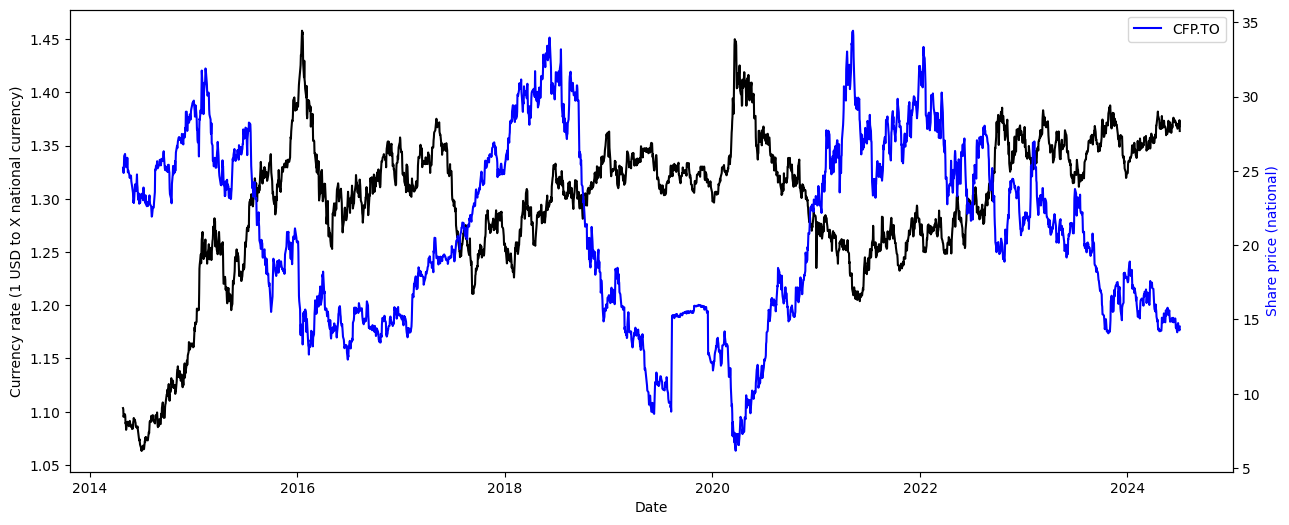

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

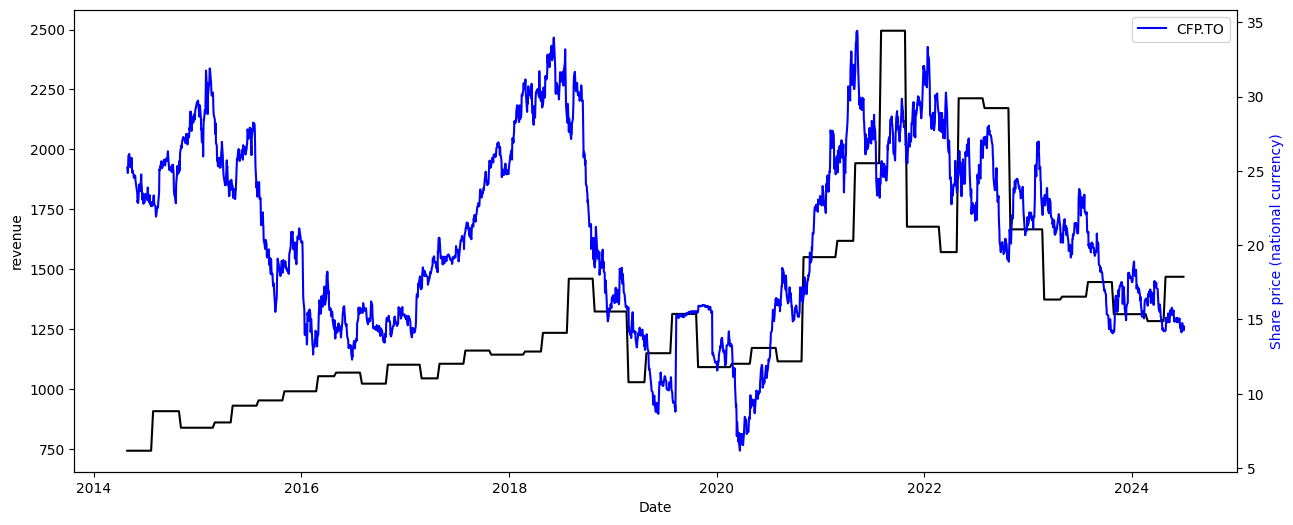

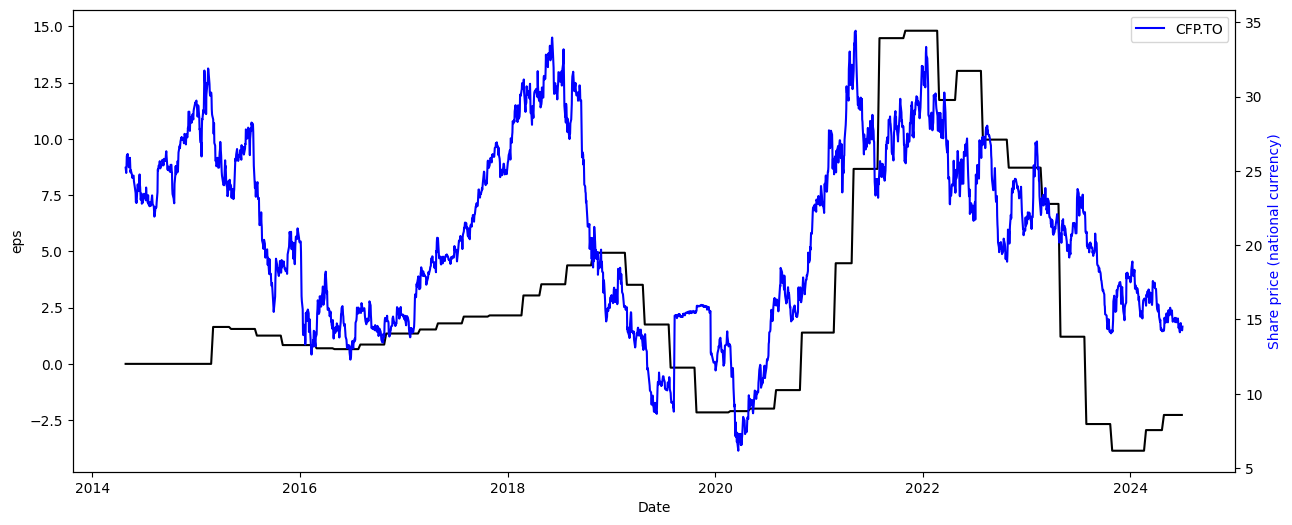

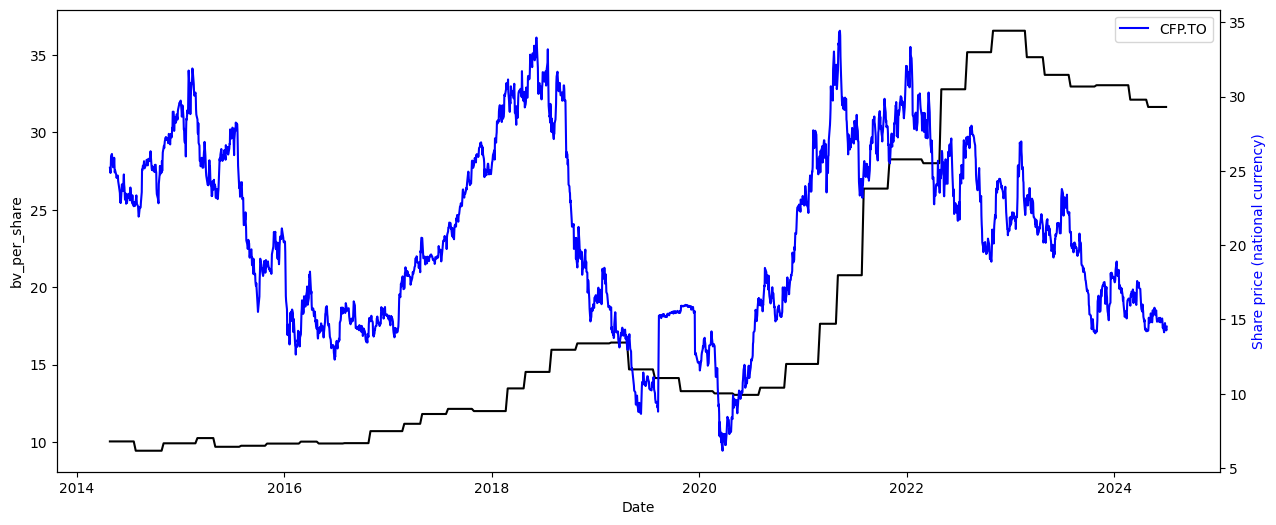

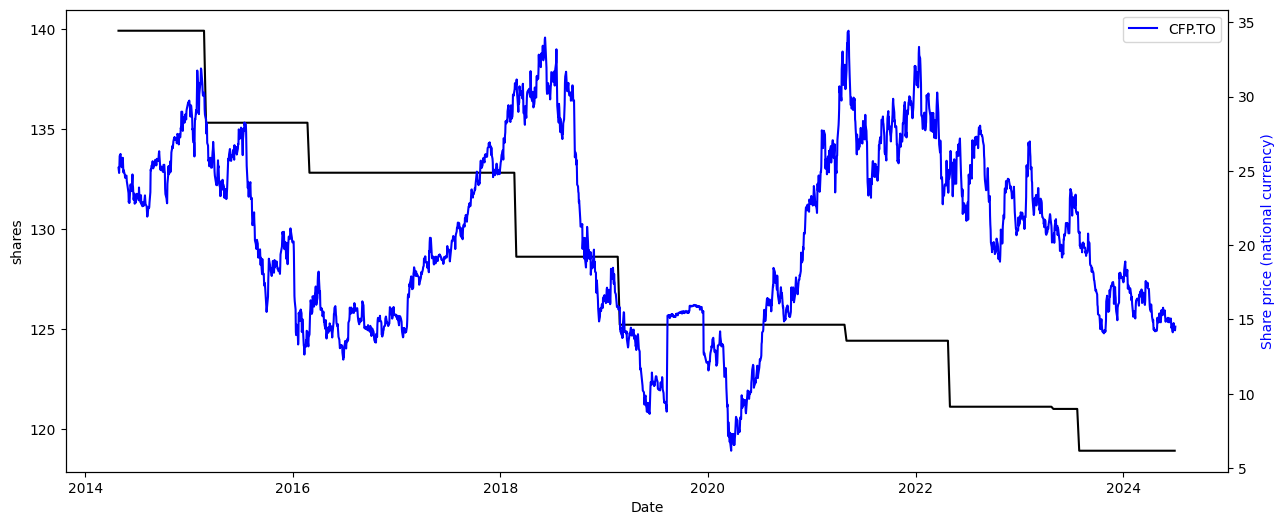

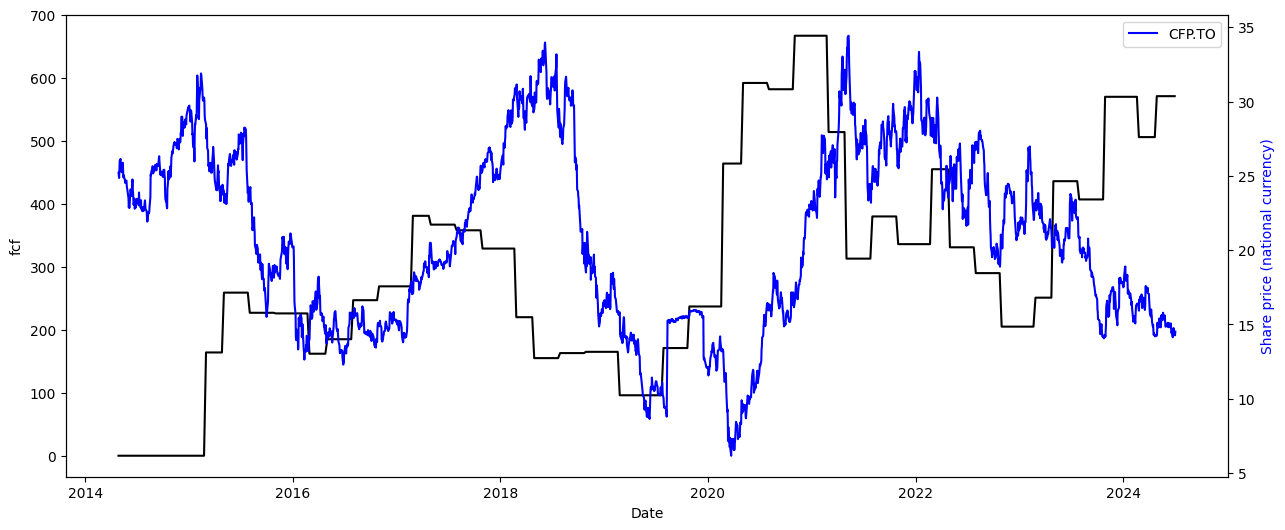

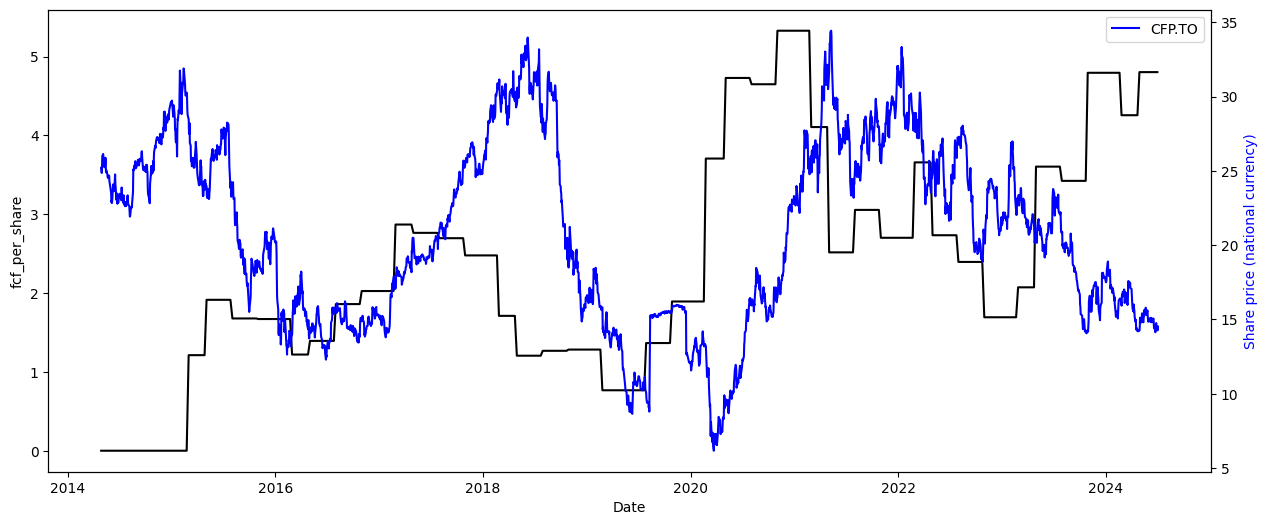

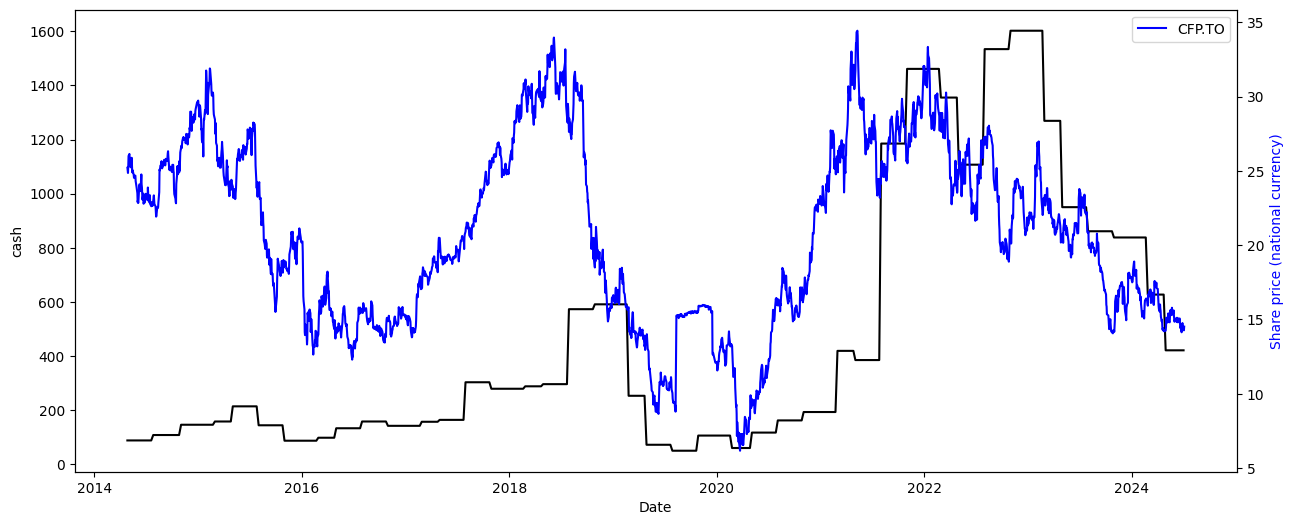

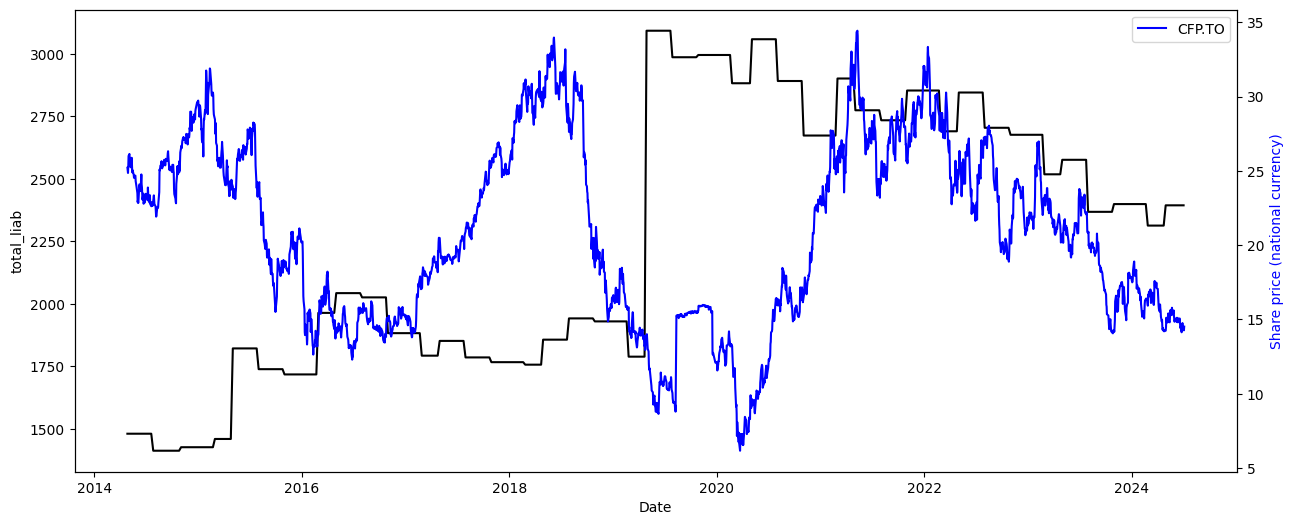

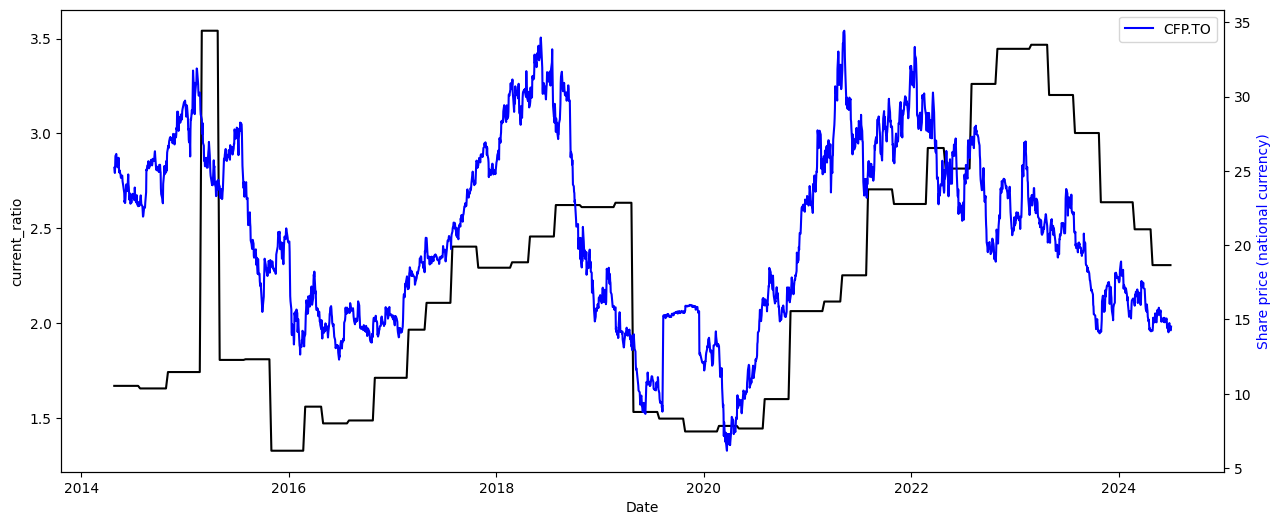

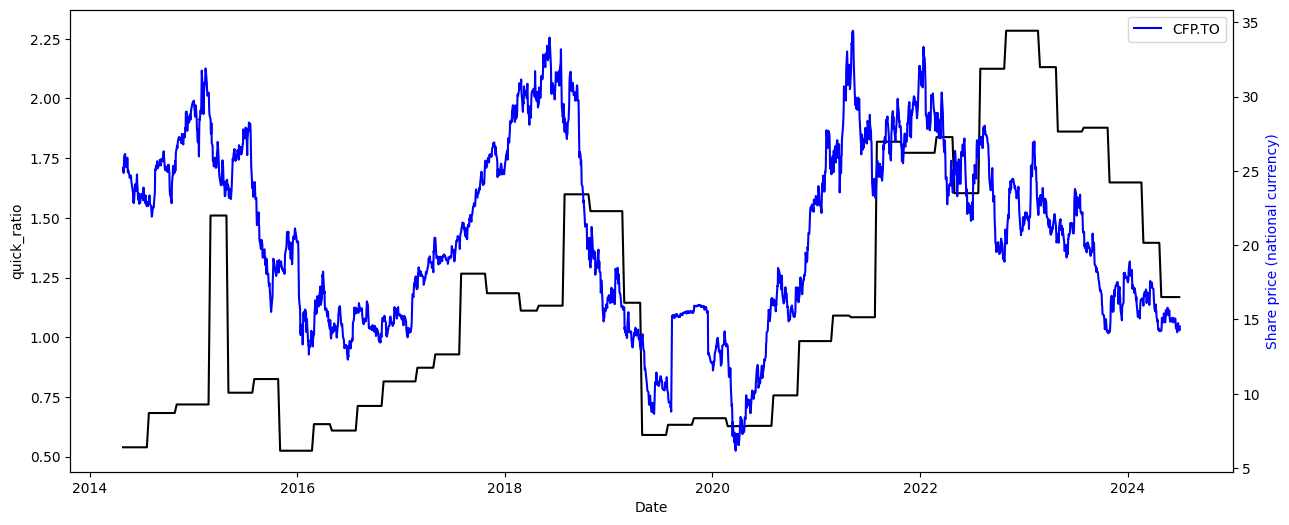

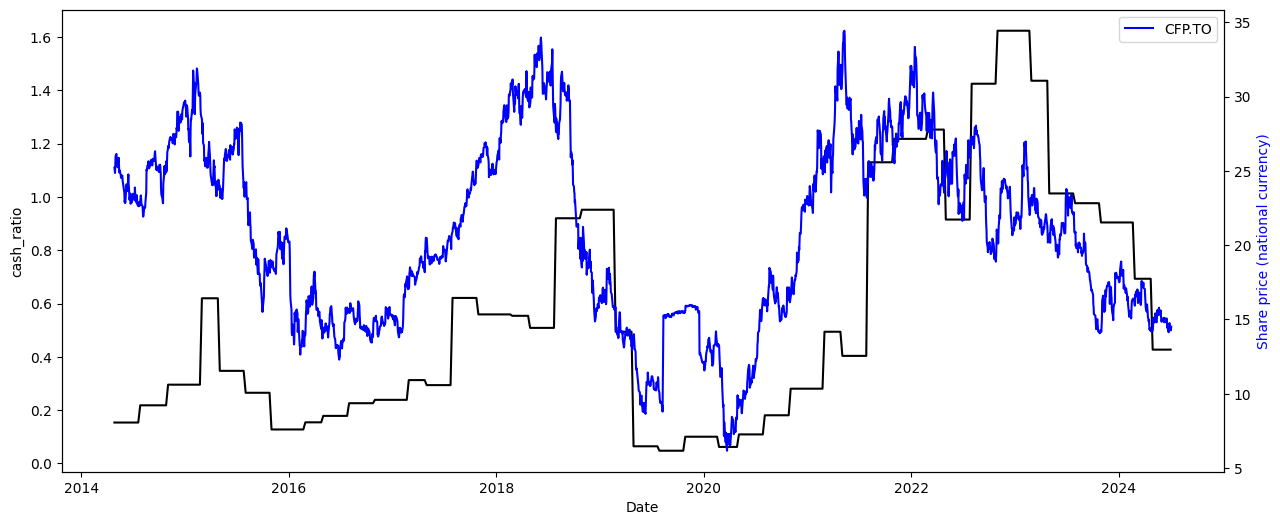

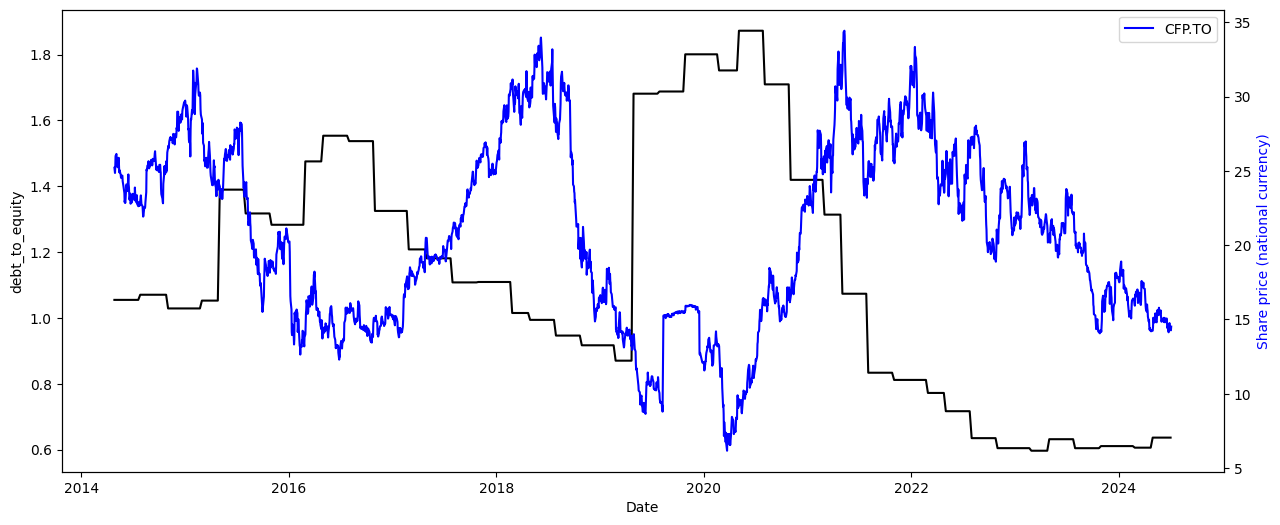

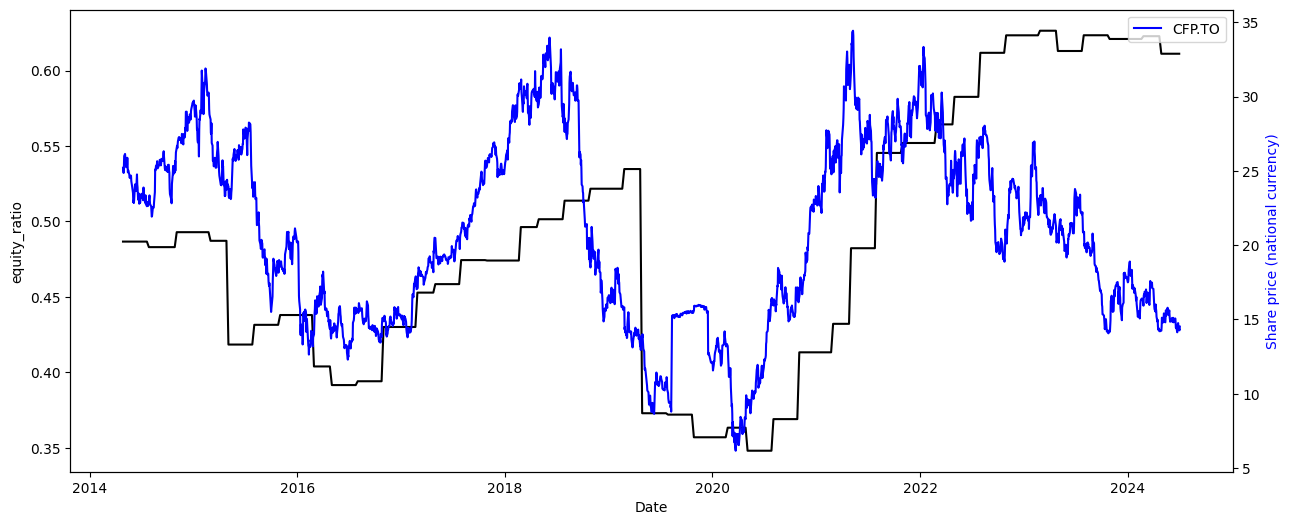

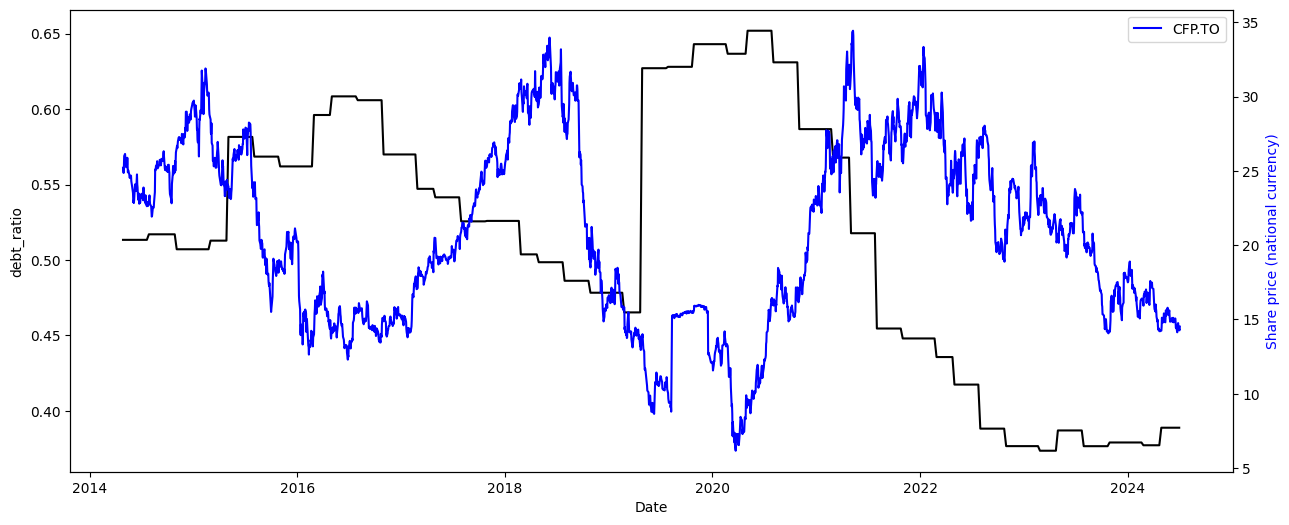

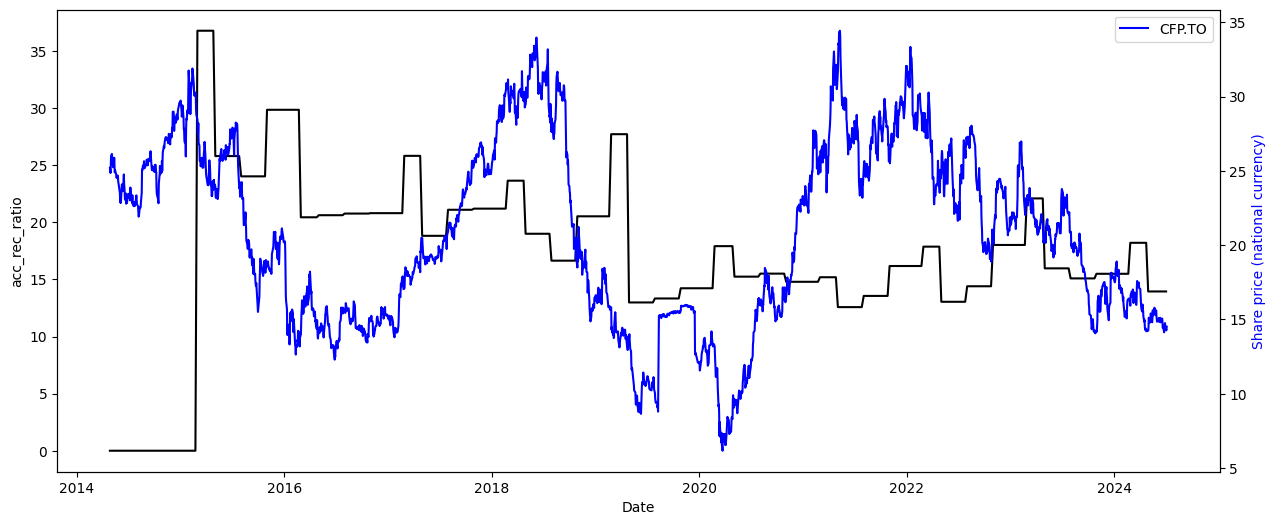

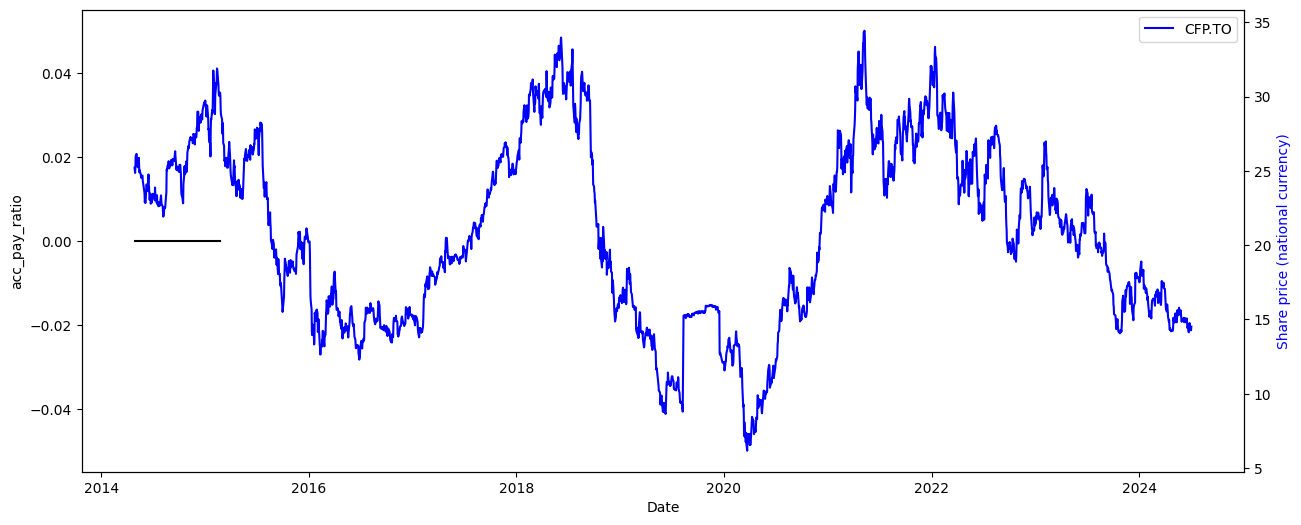

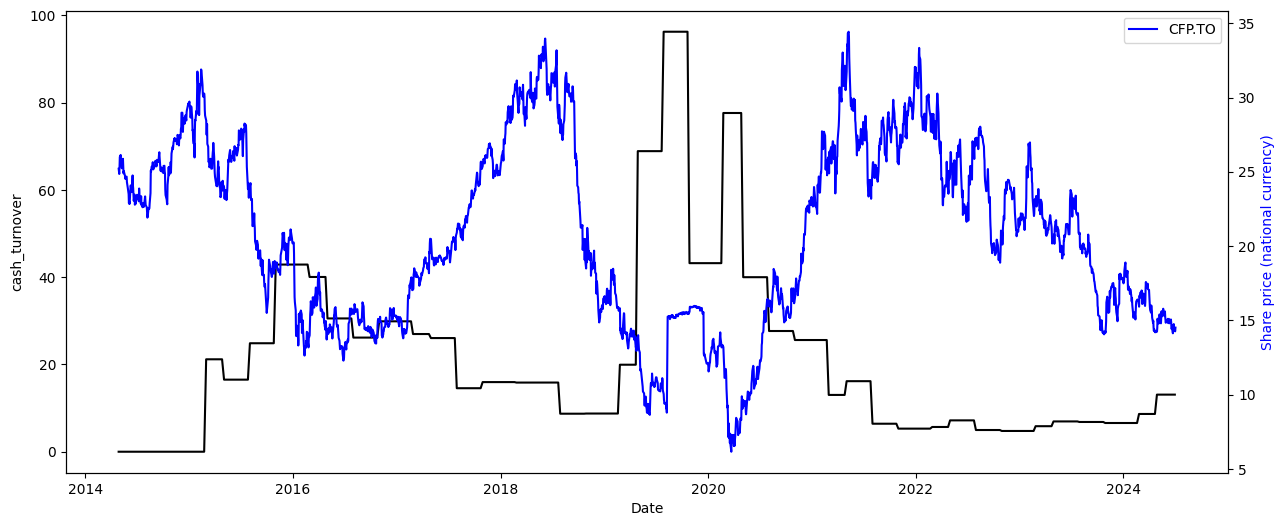

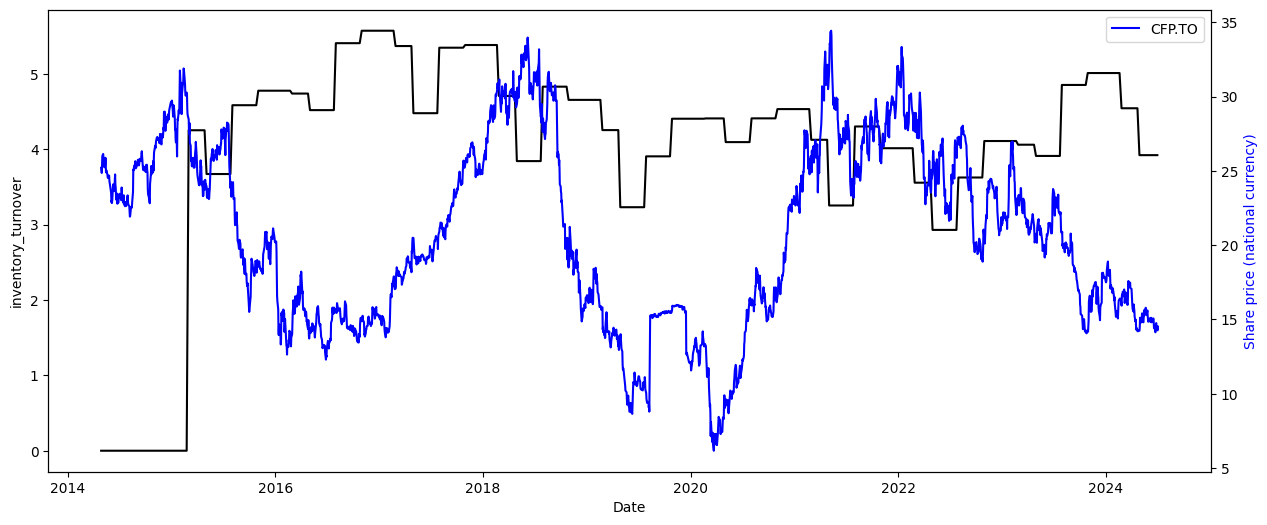

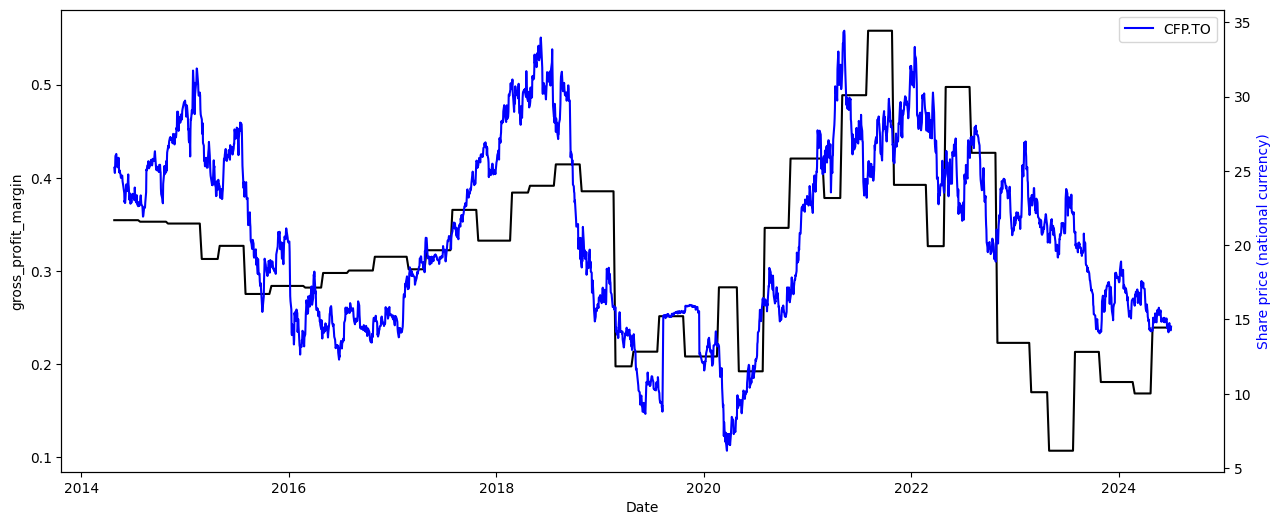

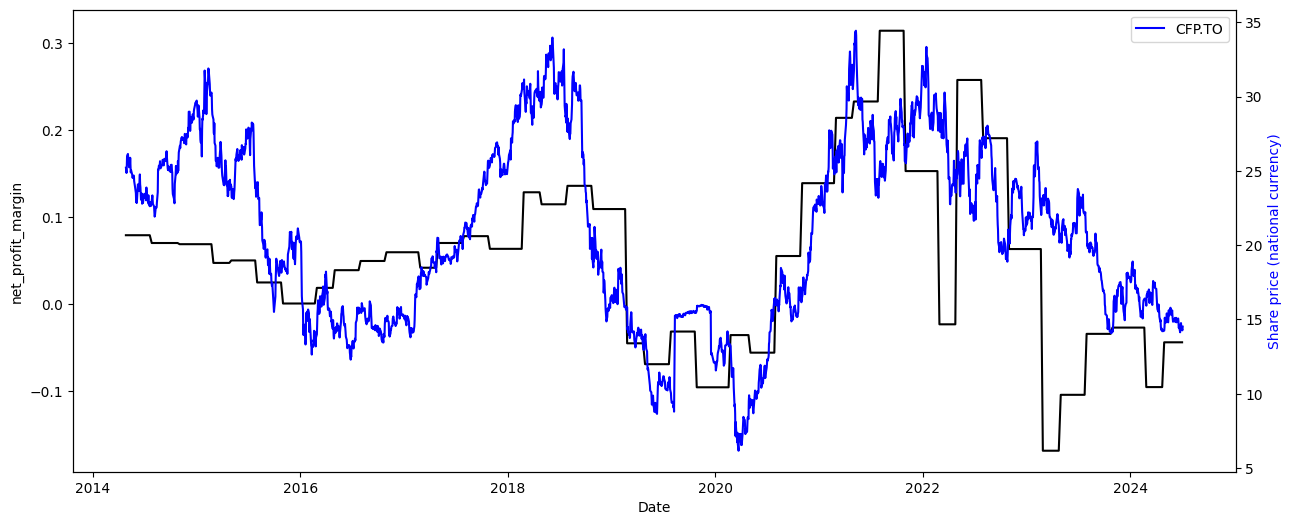

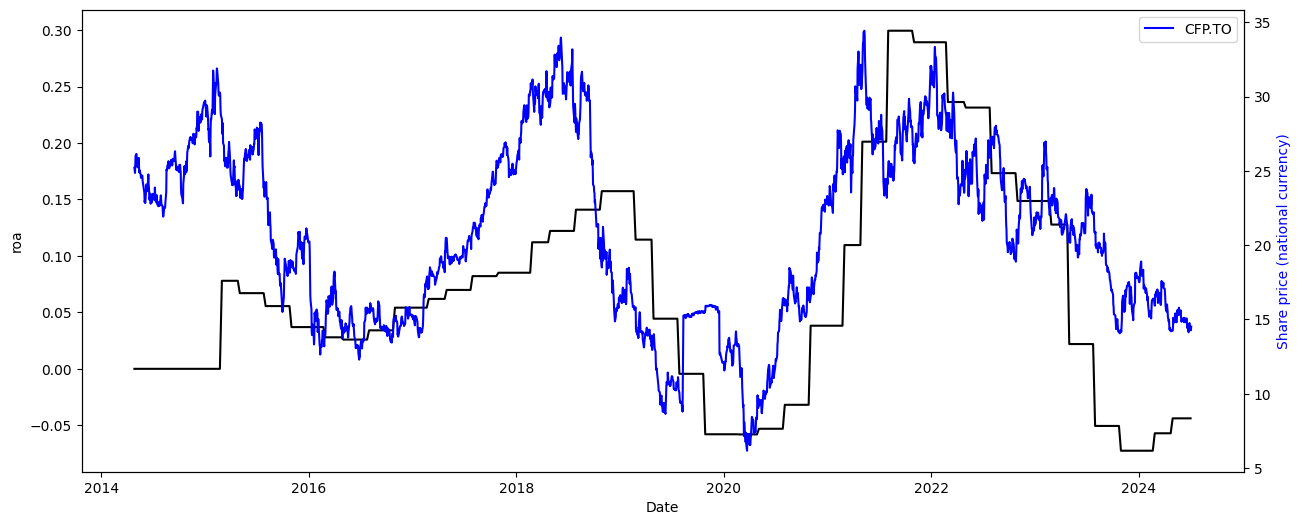

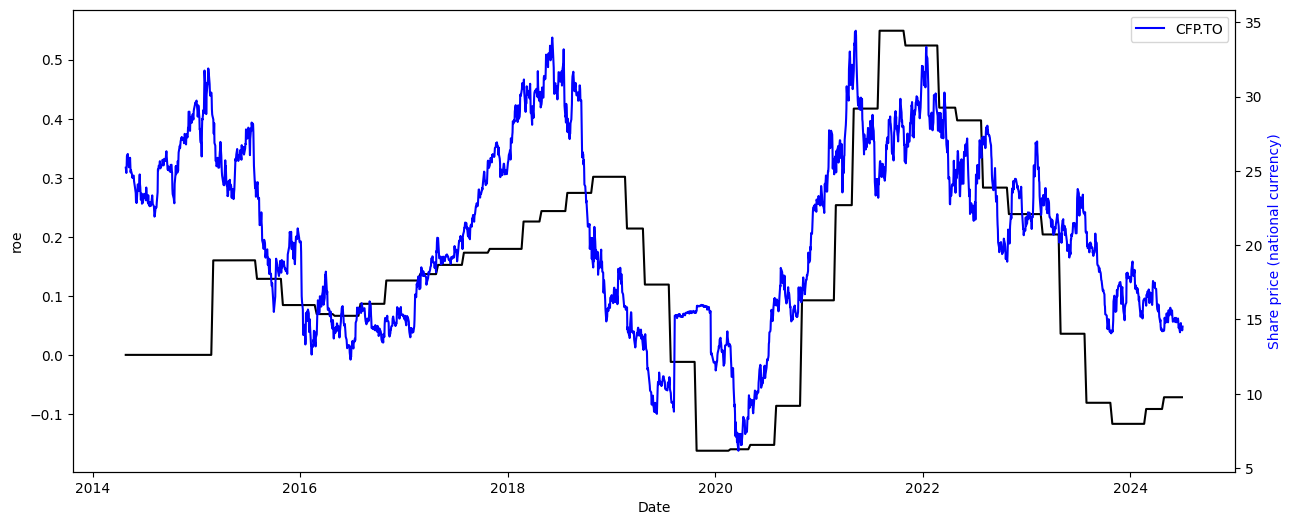

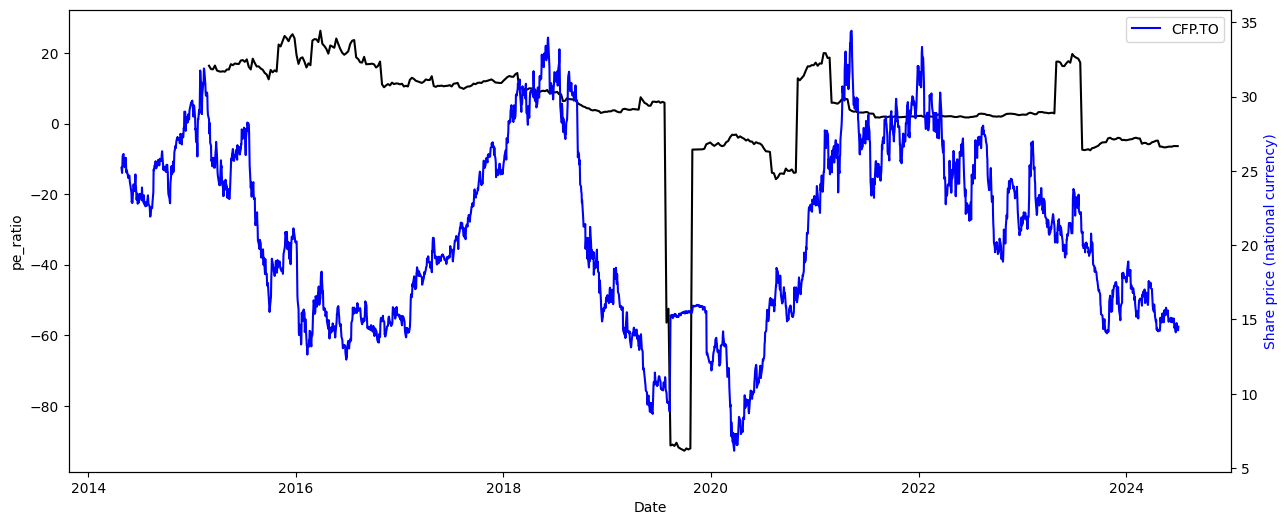

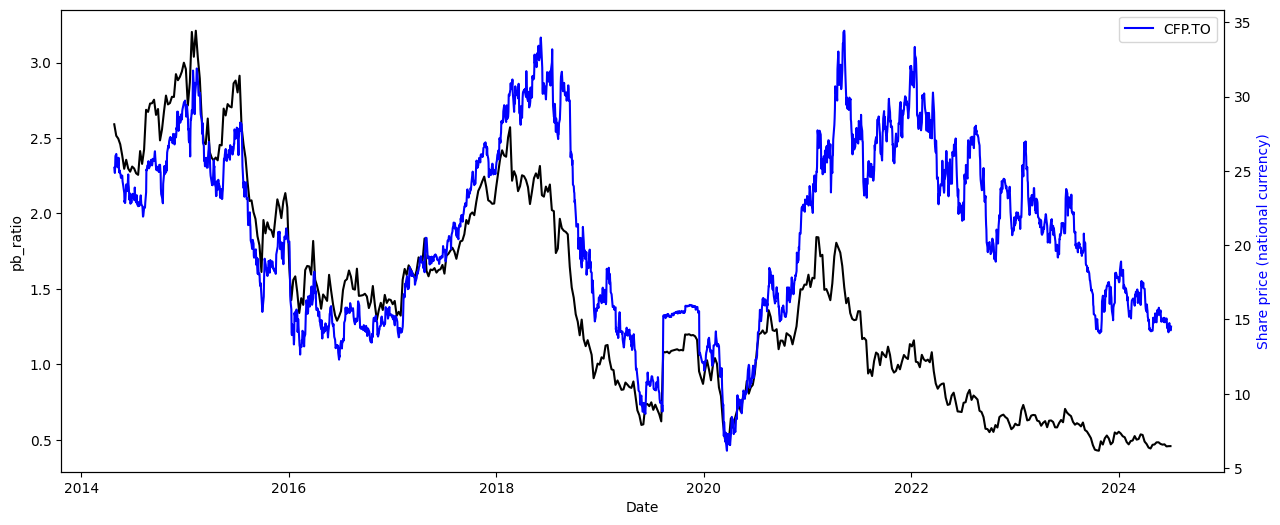

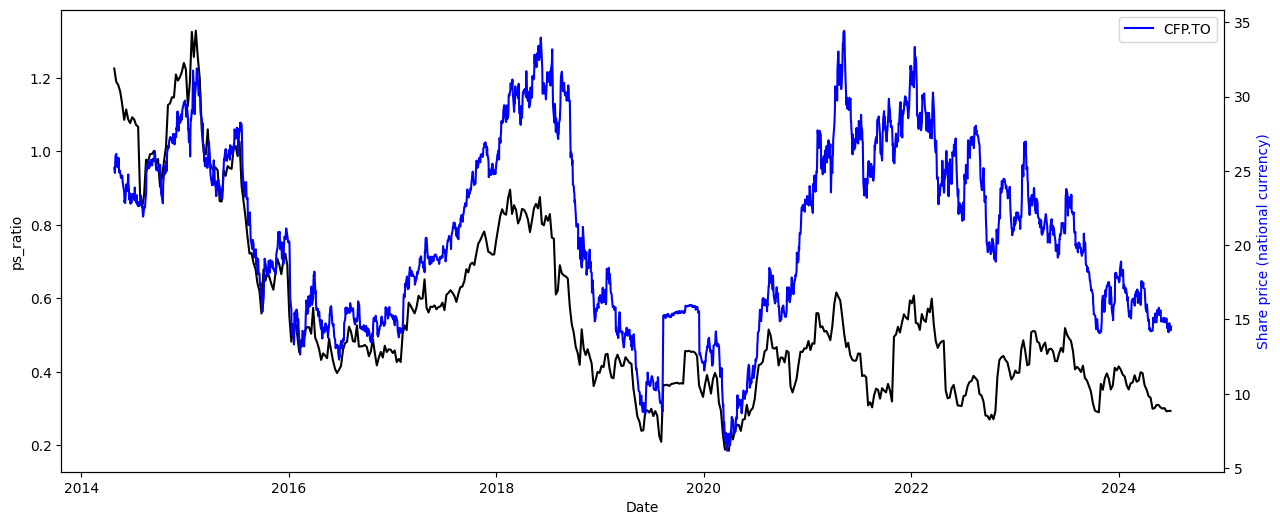

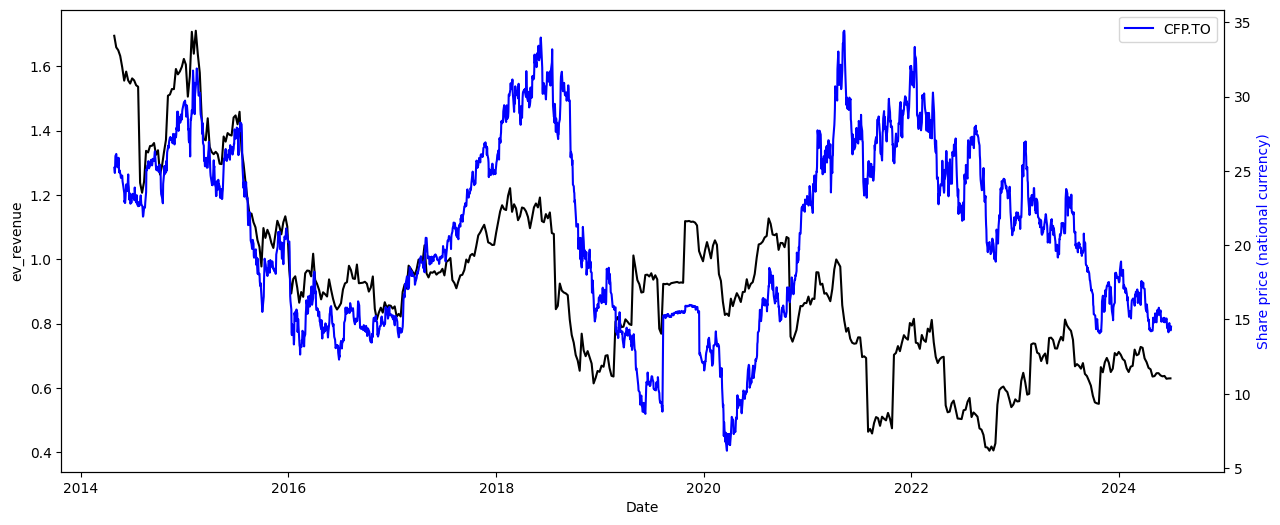

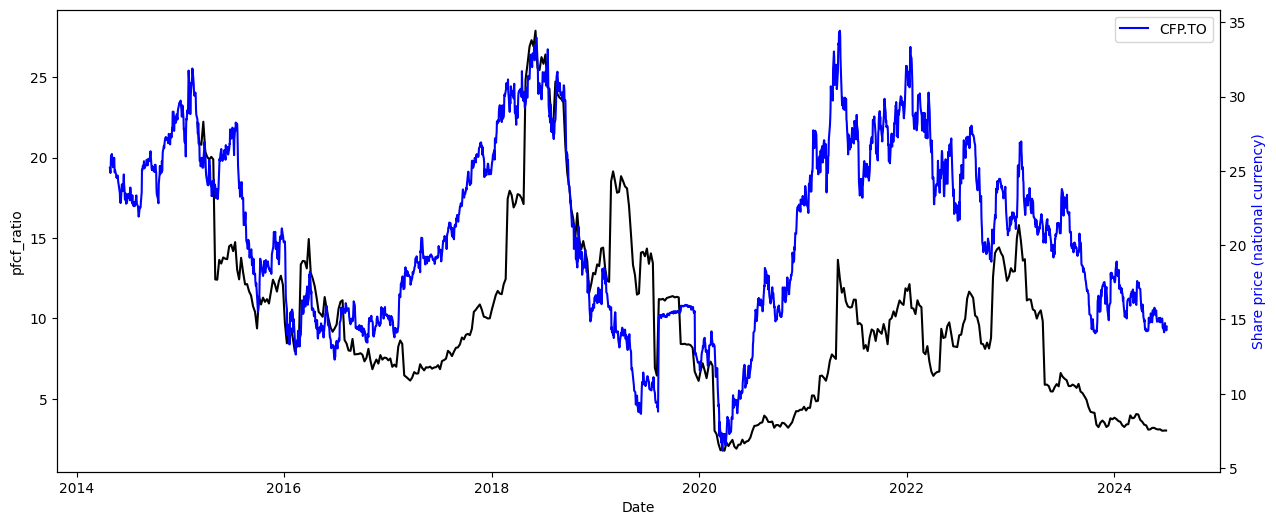

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

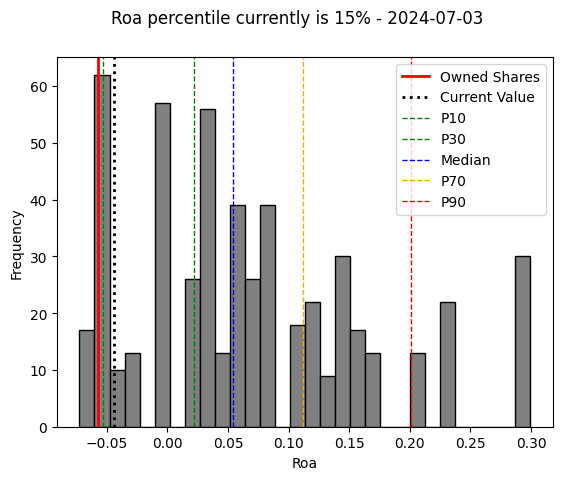

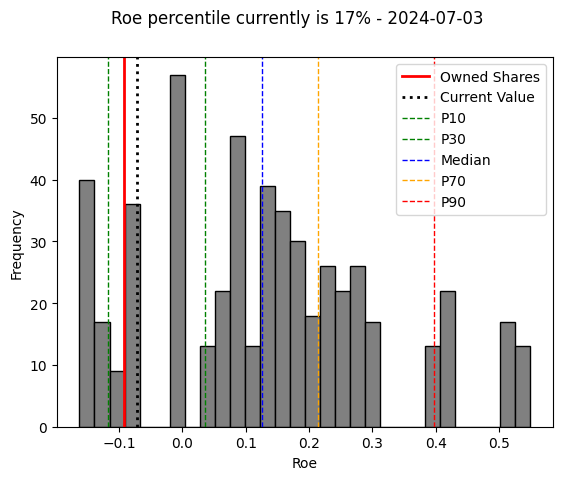

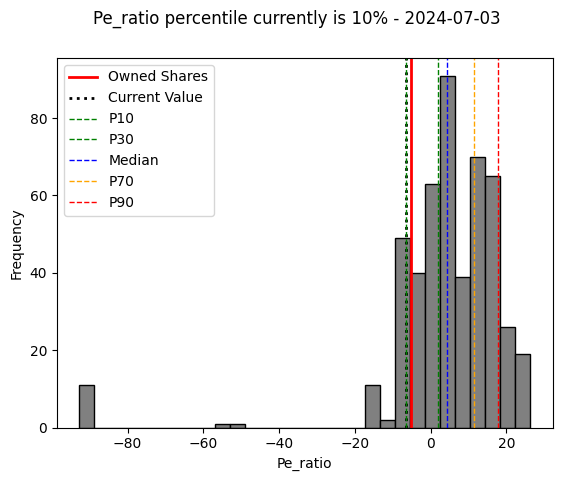

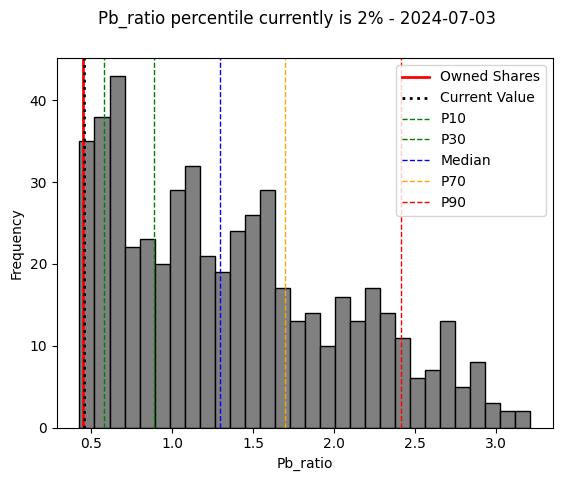

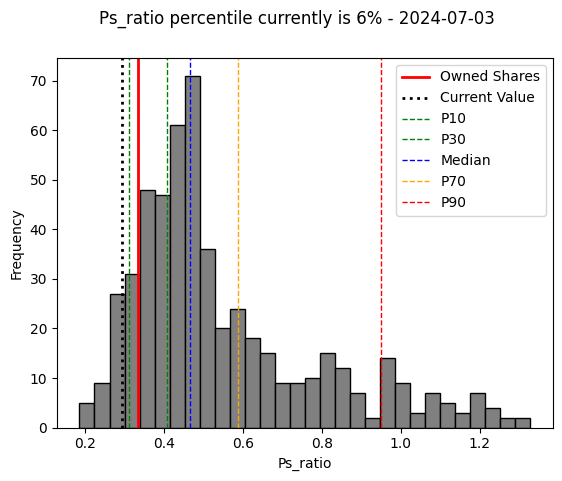

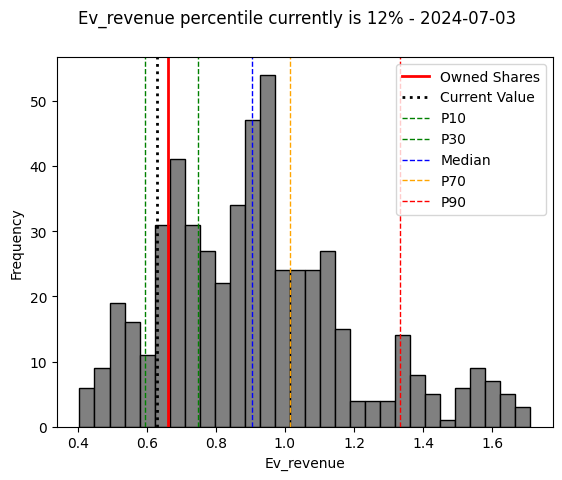

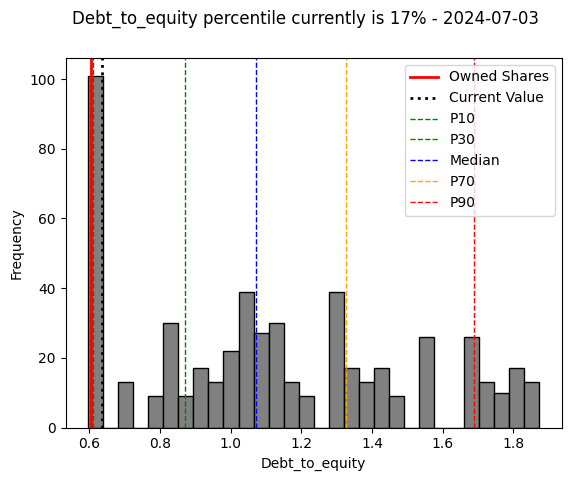

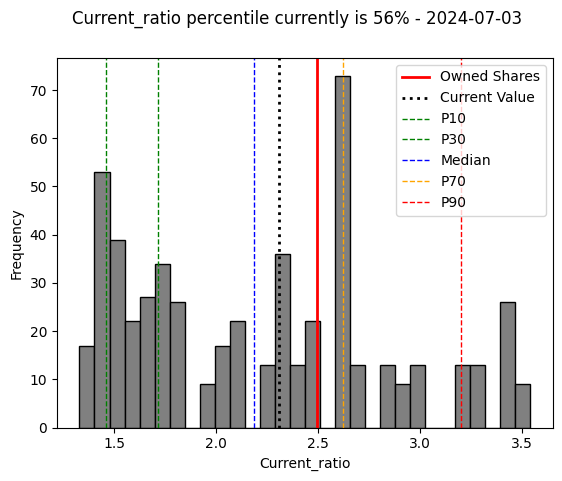

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.989281,0.180177,-0.037071,-0.040467,-0.376636,-0.411081,0.506989
roe,0.989281,1.000000,0.225989,0.021632,-0.000009,-0.341762,-0.407343,0.478999
pe_ratio,0.180177,0.225989,1.000000,0.377225,0.386382,0.175425,-0.122336,0.073949
pb_ratio,-0.037071,0.021632,0.377225,1.000000,0.917117,0.864164,0.230960,-0.355265
ps_ratio,-0.040467,-0.000009,0.386382,0.917117,1.000000,0.863879,-0.040310,-0.130632
ev_revenue,-0.376636,-0.341762,0.175425,0.864164,0.863879,1.000000,0.415113,-0.523368
debt_to_equity,-0.411081,-0.407343,-0.122336,0.230960,-0.040310,0.415113,1.000000,-0.841470
current_ratio,0.506989,0.478999,0.073949,-0.355265,-0.130632,-0.523368,-0.841470,1.000000


0 timestemos have been found!


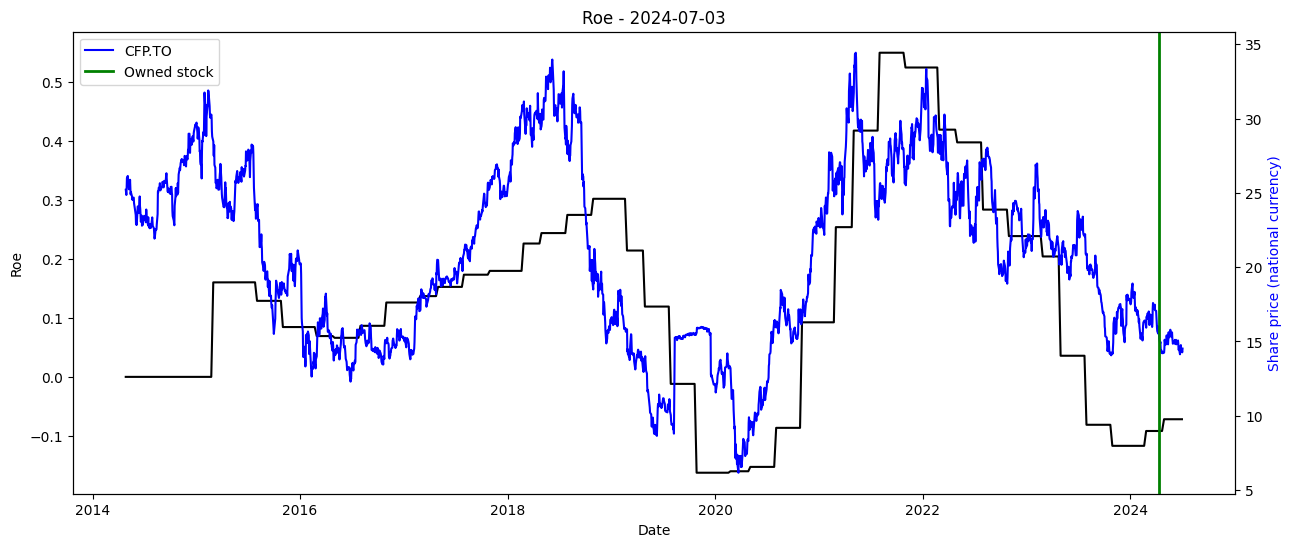

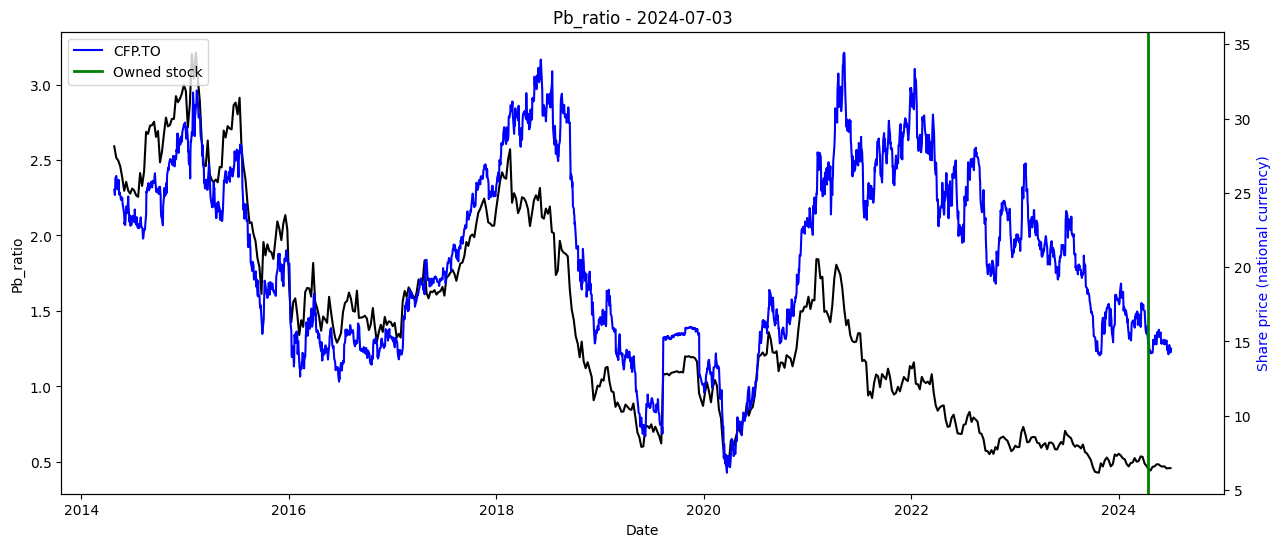

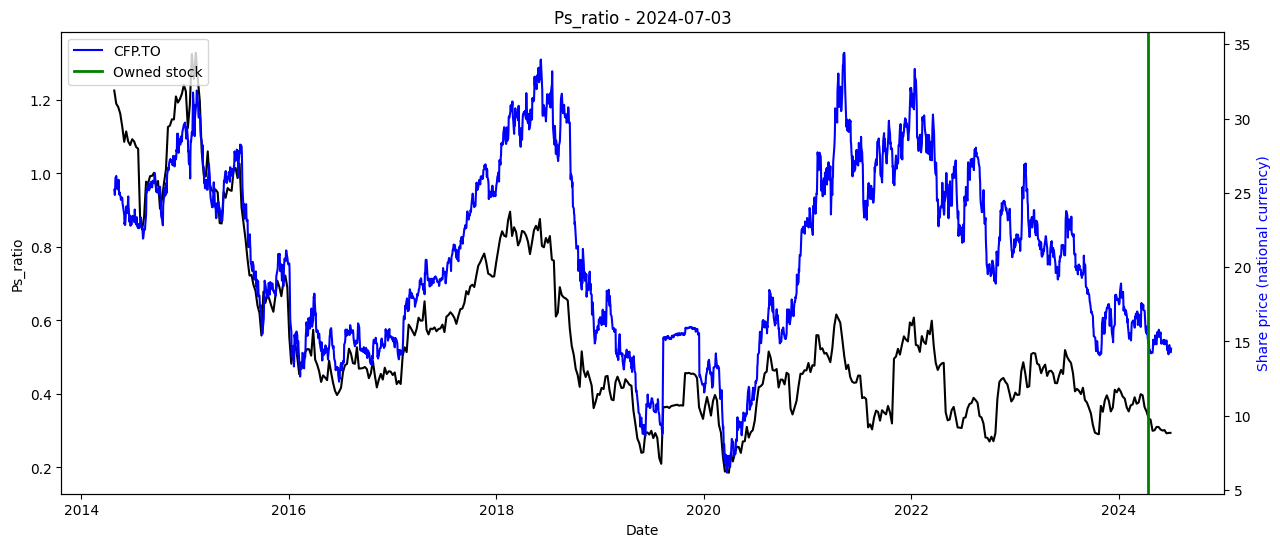

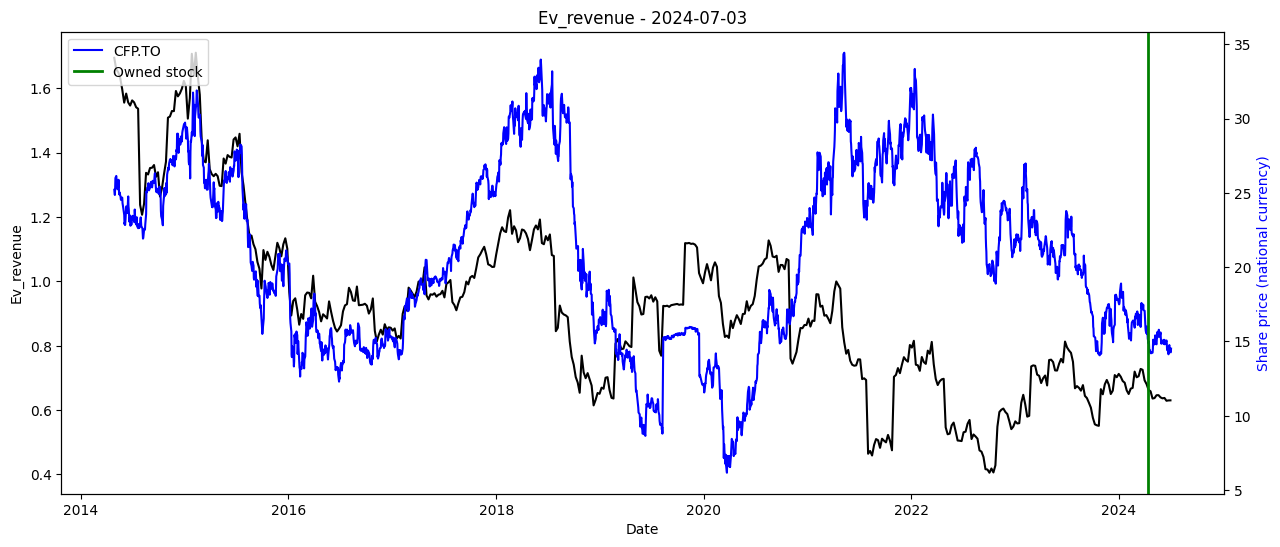

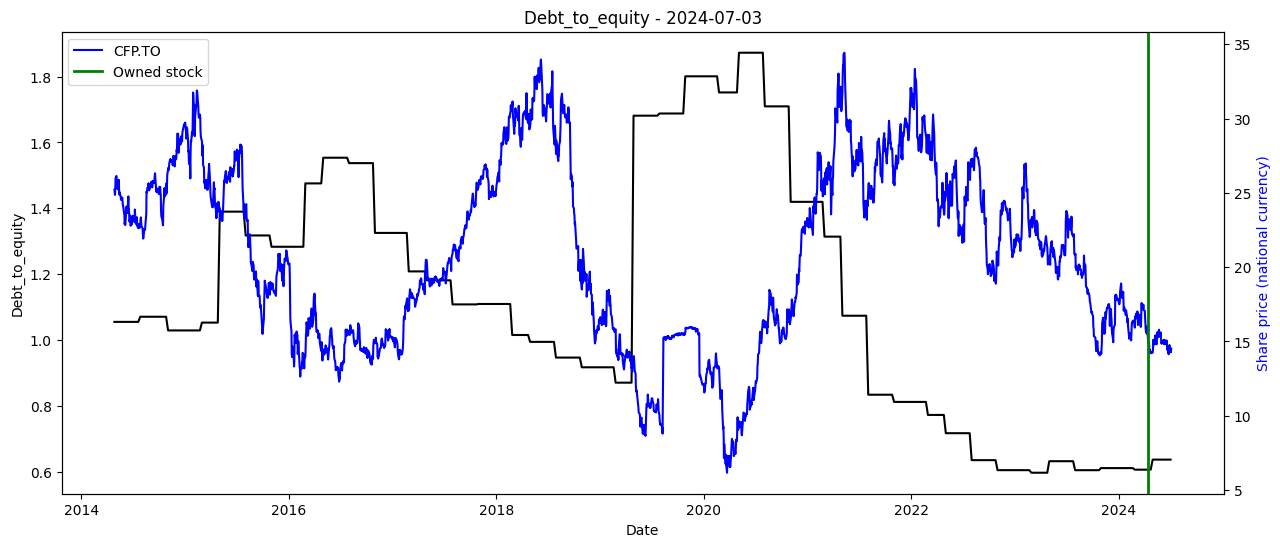

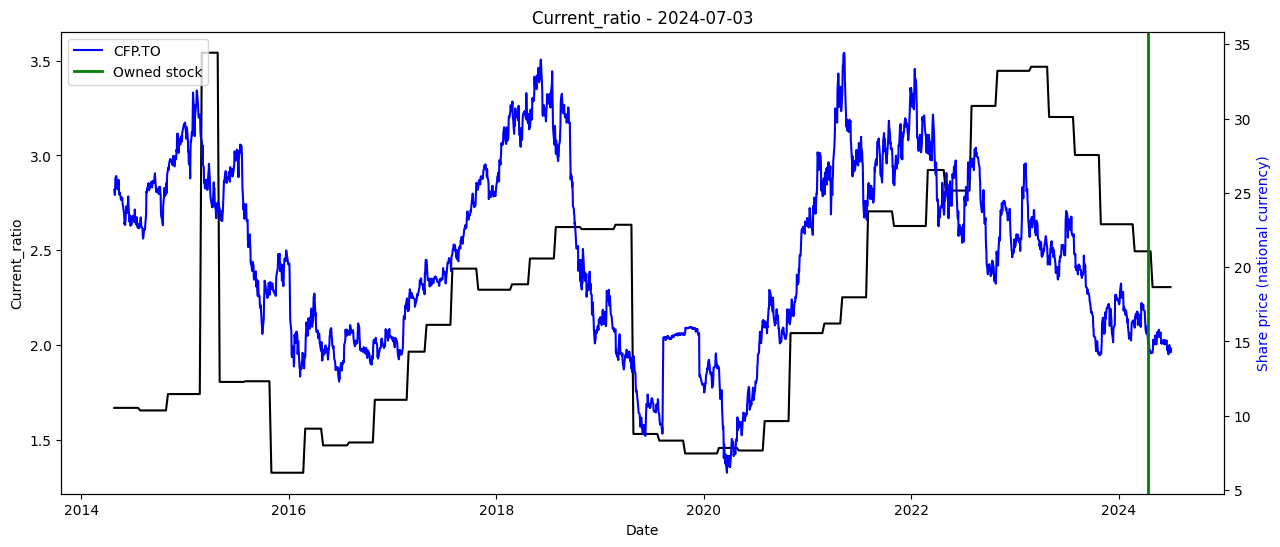

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )